In [30]:
#General import
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit import transpile

#Qiskit import
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, SamplerV2 as Sampler

In [31]:
# ╔══════════════════════════════╗
# ║ 1. CONNECTION TO IBM SERVICE ║
# ╚══════════════════════════════╝

#Instance credentials
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token="MY_TOKEN_API",
    instance="crn:--MY_Instance::"
    )
print("Connected!")
print("Available backends:", [b.name for b in service.backends()])

# Backend selection
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=133)
print(f"Selected backend: {backend.name}")
print(f"Qubits number: {backend.configuration().num_qubits}")
print(f"Version: {backend.version}")

Connected!
Available backends: ['ibm_brisbane', 'ibm_sherbrooke', 'ibm_torino']
Selected backend: ibm_torino
Qubits number: 133
Version: 2



Parametrized circuit:


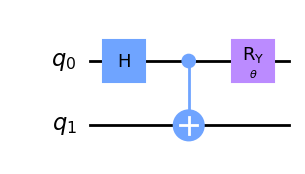

In [32]:
# ╔══════════════════════════════════╗
# ║ 2. PARAMETRIZED CIRCUIT BUILDING ║
# ╚══════════════════════════════════╝

theta = Parameter("$\\theta$")
qc = QuantumCircuit(2)

# Bell state preparation |Φ⁺⟩
qc.h(0)
qc.cx(0, 1)

# Parametrized rotation
qc.ry(theta, 0)

print("\nParametrized circuit:")
qc.draw(output="mpl", idle_wires=False, style="clifford", filename="IBM_Torino_qc_param.svg")

In [33]:
# ╔════════════════════════════════════════════╗
# ║ 3. TEST - CHECK BELL STATE PREPARATION     ║
# ╚════════════════════════════════════════════╝
'''
#The errors could be related to a non-correct Bell state preparation!

# "statevector" simulation method
simulator = AerSimulator(method="statevector")

# Fixing paramether value
bound_circuit = qc.assign_parameters({theta: 0})

# Statevector saving
bound_circuit.save_statevector()

# Job execution
job = simulator.run(bound_circuit, shots=1)
result = job.result()

#Print result (Bell state expected)
statevector = result.get_statevector(bound_circuit)
print("Resulting statevector:", statevector)
'''

'\n#The errors could be related to a non-correct Bell state preparation!\n\n# "statevector" simulation method\nsimulator = AerSimulator(method="statevector")\n\n# Fixing paramether value\nbound_circuit = qc.assign_parameters({theta: 0})\n\n# Statevector saving\nbound_circuit.save_statevector()\n\n# Job execution\njob = simulator.run(bound_circuit, shots=1)\nresult = job.result()\n\n#Print result (Bell state expected)\nstatevector = result.get_statevector(bound_circuit)\nprint("Resulting statevector:", statevector)\n'

In [34]:
#BACKEND TOPOLOGY
config = backend.configuration()
coupling_map = config.coupling_map
print("Coupling Map:", coupling_map)       #show qubits hardware structure

Coupling Map: [[0, 1], [0, 15], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 16], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [8, 17], [9, 8], [9, 10], [10, 9], [10, 11], [11, 10], [11, 12], [12, 11], [12, 13], [12, 18], [13, 12], [13, 14], [14, 13], [15, 0], [15, 19], [16, 4], [16, 23], [17, 8], [17, 27], [18, 12], [18, 31], [19, 15], [19, 20], [20, 19], [20, 21], [21, 20], [21, 22], [21, 34], [22, 21], [22, 23], [23, 16], [23, 22], [23, 24], [24, 23], [24, 25], [25, 24], [25, 26], [25, 35], [26, 25], [26, 27], [27, 17], [27, 26], [27, 28], [28, 27], [28, 29], [29, 28], [29, 30], [29, 36], [30, 29], [30, 31], [31, 18], [31, 30], [31, 32], [32, 31], [32, 33], [33, 32], [33, 37], [34, 21], [34, 40], [35, 25], [35, 44], [36, 29], [36, 48], [37, 33], [37, 52], [38, 39], [38, 53], [39, 38], [39, 40], [40, 34], [40, 39], [40, 41], [41, 40], [41, 42], [42, 41], [42, 43], [42, 54], [43, 42], [43, 44], [44, 35], [44, 43], [44, 45], [45, 44], [45, 46],

In [35]:
# ╔═══════════════════════════════╗
# ║ 4. SEARCHING BEST QUBITS PAIR ║
# ╚═══════════════════════════════╝

# 1) Dictionary buliding {qubit: avg_coherence}
coherences = {}
props = backend.properties()
for i, q_props in enumerate(props.qubits):
    try:
        t1 = next(p.value for p in q_props if p.name=='T1')
        t2 = next(p.value for p in q_props if p.name=='T2')
        coherences[i] = (t1 + t2) / 2
    except StopIteration:
        # skip qubit without T1/T2
        pass

# 2) Take the coupling_map (direct connected pairs) and normalize it to non-ordered edges
cm = backend.configuration().coupling_map  # ex. [[0,1],[1,2],…]
undirected = set()
for u, v in cm:
    # in order to consider (u,v) same of (v,u)
    undirected.add(frozenset((u, v)))

# 3) Find maximum average coherence edge
best_pair = None
best_score = -1
for edge in undirected:
    u, v = tuple(edge)

    if u not in coherences or v not in coherences:
        continue
    score = (coherences[u] + coherences[v]) / 2
    if score > best_score:
        best_score = score
        best_pair = (u, v)

print(f"Best Pair: {best_pair} with average coherence {best_score:.1f}µs")
print("Use initial_layout =", list(best_pair))


Best Pair: (88, 87) with average coherence 289.8µs
Use initial_layout = [88, 87]


In [36]:
# ╔════════════════════════════════════════════╗
# ║ 5. OBSERVABLE DEFINITION - PHASES CREATION ║
# ╚════════════════════════════════════════════╝
chsh1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])
chsh2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

num_phases = 30                                 #phases creation
phases = np.linspace(0, 2 * pi, num_phases)
param_bindings = [[phase] for phase in phases]
#Parameter check variation
print(param_bindings)
print(len(param_bindings))


print("\nOsservabili CHSH:")
print("CHSH1:", chsh1)
print("CHSH2:", chsh2)

[[np.float64(0.0)], [np.float64(0.21666156231653746)], [np.float64(0.43332312463307493)], [np.float64(0.6499846869496124)], [np.float64(0.8666462492661499)], [np.float64(1.0833078115826873)], [np.float64(1.2999693738992248)], [np.float64(1.5166309362157622)], [np.float64(1.7332924985322997)], [np.float64(1.9499540608488373)], [np.float64(2.1666156231653746)], [np.float64(2.383277185481912)], [np.float64(2.5999387477984497)], [np.float64(2.8166003101149872)], [np.float64(3.0332618724315243)], [np.float64(3.249923434748062)], [np.float64(3.4665849970645994)], [np.float64(3.683246559381137)], [np.float64(3.8999081216976745)], [np.float64(4.116569684014212)], [np.float64(4.333231246330749)], [np.float64(4.549892808647287)], [np.float64(4.766554370963824)], [np.float64(4.983215933280362)], [np.float64(5.199877495596899)], [np.float64(5.416539057913437)], [np.float64(5.6332006202299745)], [np.float64(5.849862182546511)], [np.float64(6.066523744863049)], [np.float64(6.283185307179586)]]
30

O

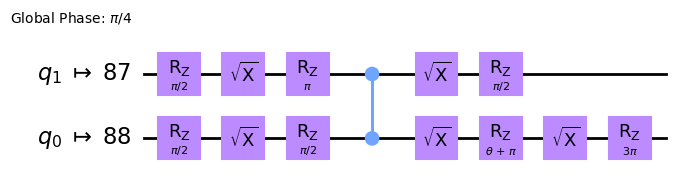

In [37]:
# ╔══════════════════════════════════════════════════════════╗
# ║ 6. ISA OPTIMIZATION (transpiler) ON PARAMETRIZED CIRCUIT ║
# ╚══════════════════════════════════════════════════════════╝

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = transpile(qc,
                             backend,
                             layout_method='trivial',                  #force to take the initial_layout
                             initial_layout= best_pair,                #Initial layout using best qubits pair
                             optimization_level=3, seed_transpiler=42) #optimization
isa_observable1 = chsh1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = chsh2.apply_layout(layout=chsh_isa_circuit.layout)

chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="clifford",filename="IBM_Torino_qc_ISA.svg")

In [38]:
# ╔═══════════════════════════════════════════╗
# ║ 7. SINGLE "pub" ESTIMATOR - JOB EXECUTION ║
# ╚═══════════════════════════════════════════╝
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 2
estimator.options.default_shots = 8192       # Shot Number

pub = (
    chsh_isa_circuit,                        # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    param_bindings,                          # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

print("CHSH1 values:", chsh1_est)
print("CHSH2 values:", chsh2_est)

Valori CHSH1: [ 1.9891909   1.50624365  0.97866247  0.34281972 -0.21215468 -0.84376409
 -1.43364488 -1.85144608 -2.30652237 -2.59480786 -2.76092129 -2.86453326
 -2.75641167 -2.5363726  -2.1762193  -1.75149664 -1.23309806 -0.67713056
 -0.1030929   0.53701269  1.13092162  1.65504668  2.08990971  2.48511439
  2.68022656  2.8239482   2.75900126  2.66098811  2.38555409  2.02418598]
Valori CHSH2: [ 2.00774348  2.36621014  2.65737782  2.81015209  2.8314484   2.69607448
  2.4243997   2.14092076  1.6492171   1.08430068  0.52900149 -0.07302711
 -0.68934225 -1.24518139 -1.7777046  -2.22071852 -2.54362323 -2.73298731
 -2.79306455 -2.75970491 -2.58545818 -2.28299709 -1.9144468  -1.34946823
 -0.82729497 -0.23249727  0.37556354  0.99708323  1.54686655  1.96628007]


'\nchsh1_est = [1.95062666,1.43896696,0.90846943,0.31659704,-0.35488036,-0.94736043,-1.54409419,-1.9585264,-2.38450437,-2.67679453,-2.8566654,-2.9344474,-2.77219901,-2.55282947,\n              -2.18397265,-1.73368781,-1.20440562,-0.64899354,-0.01033042,0.5809343,1.21230536,1.68021269,2.14568933,2.54310672,2.74728447,2.86213445,\n              2.81109001,2.6579567,2.36080517,1.93665021]\nchsh2_est = [2.00653247,2.37113559,2.67436384,2.86274212,2.73452336,2.68773262,2.3450057,\n                1.9390809,1.57994683,1.02271174,0.45028485,-0.15617167,-0.78511204,-1.37151538,-1.90201291,\n                -2.28302317,-2.60205089,-2.79529054,-2.86274212,-2.80015192,-2.59293581,-2.27694645,-1.90262058,\n                -1.31317888,-0.82582605,-0.21025446,0.40714014,1.02453475,1.56475503,2.03873908]\n'

In [57]:
# ╔════════════════════════════╗
# ║ 8. S PARAMETER COMPUTATION ║
# ╚════════════════════════════╝

S_values = np.maximum(np.abs(chsh1_est), np.abs(chsh2_est))
S_max = np.max(S_values)

S_mean = np.mean(S_values)
S_std = np.std(S_values, ddof=1)

print("\n" + "═"*26)
print("CHSH Results:")
print("═"*26)
print("S parameters for each binding:", S_values)
print(f"Maximum Bell violation (S_max): {S_max:.4f}")
# Mean and standard dev
print(f"S mean value: {S_mean:.4f} ± {S_std:.4f}")

# ╔═══════════════════╗
# ║ 9. ERROR ANALYSIS ║
# ╚═══════════════════╝
print("\nError analysis:")
properties = backend.properties()

# mean gate errors
cx_errors = [properties.gate_error('cx', [int(q[0]), int(q[1])])
             for q in properties.gates if q.gate == 'cx' and len(q.qubits) == 2]
avg_cx_error = np.mean(cx_errors) if cx_errors else 0

rz_errors = [properties.gate_error('rz', q) for q in range(backend.configuration().num_qubits)]
avg_rz_error = np.mean(rz_errors) if rz_errors else 0

avg_rz_error = np.mean(rz_errors) if rz_errors else 0

sx_errors = [properties.gate_error('sx', q) for q in range(backend.configuration().num_qubits)]
avg_sx_error = np.mean([properties.gate_error('sx', q) for q in range(backend.configuration().num_qubits)])

# Reading errors
readout_errors = [properties.readout_error(q) for q in range(backend.configuration().num_qubits)]
avg_readout_error = np.mean(readout_errors) if readout_errors else 0

print(f"Mean CX gate error: {avg_cx_error:.4f}")
print(f"Mean RZ gate error: {avg_rz_error:.4f}")
print(f"Mean SX gate error: {avg_sx_error:.4f}")
print(f"Mean reading error: {avg_readout_error:.4f}")

# ╔══════════════════════════════╗
# ║ 10. CRYTICAL ANALYSIS RESULT ║
# ╚══════════════════════════════╝
print("\n" + "═"*26)
print("Critical analysis results")
print("═"*26)
print(f"1. Inequality violation: {S_max > 2}")
print(f"   - Theoretical expected value: 2√2 ≈ {2*np.sqrt(2):.4f}")
print(f"   - Experimental value: {S_max:.4f}")
print(f"   - Deviation: {(2*np.sqrt(2) - S_max):.4f}")

print("\n2. Main errors sources:")
print(f"   - Error gate (CX): extimated contribution ~{avg_cx_error*100:.2f}% for each operation")
print(f"   - Reading error: extimated contribution ~{avg_readout_error*100:.2f}% for each qubit")
print("   - Dechoerence: choerence loss")
print("   - Calibration errors: gate parameters imprecision")

print("\n3. Error mitigation strategy:")
print("   a) Advanced error mitigation (resilience_level=2 or 3)")
print("   b) Manual selection of initial layout (qubit pair)")
print("   c) Shots number increase")
print("   d) Error suppresion techinque (dynamical decoupling)")


══════════════════════════
CHSH Results:
══════════════════════════
S parameters for each binding: [2.00774348 2.36621014 2.65737782 2.81015209 2.8314484  2.69607448
 2.4243997  2.14092076 2.30652237 2.59480786 2.76092129 2.86453326
 2.75641167 2.5363726  2.1762193  2.22071852 2.54362323 2.73298731
 2.79306455 2.75970491 2.58545818 2.28299709 2.08990971 2.48511439
 2.68022656 2.8239482  2.75900126 2.66098811 2.38555409 2.02418598]
Maximum Bell violation (S_max): 2.8645
S mean value: 2.5253 ± 0.2655

Error analysis:
Mean CX gate error: 0.0000
Mean RZ gate error: 0.0000
Mean SX gate error: 0.0081
Mean reading error: 0.0334

══════════════════════════
Critical analysis results
══════════════════════════
1. Inequality violation: True
   - Theoretical expected value: 2√2 ≈ 2.8284
   - Experimental value: 2.8645
   - Deviation: -0.0361

2. Main errors sources:
   - Error gate (CX): extimated contribution ~0.00% for each operation
   - Reading error: extimated contribution ~3.34% for each qu

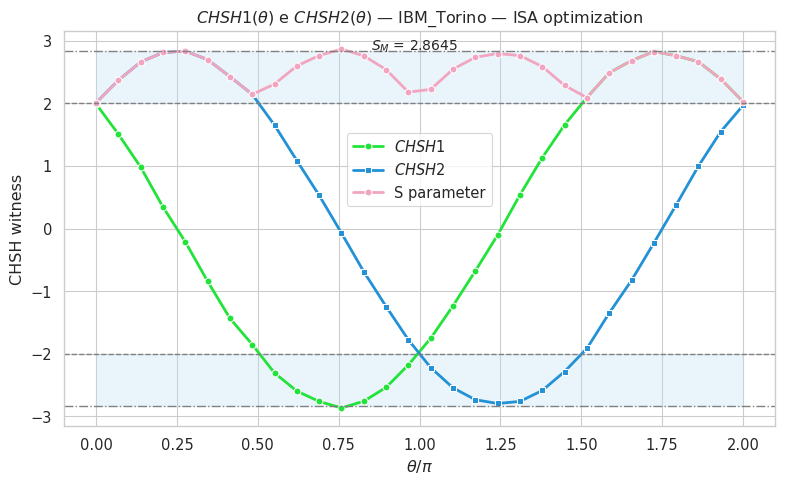

In [67]:
sns.set_theme(context='paper', style='whitegrid', palette='bright', font_scale=1.2)
plt.figure(figsize=(8, 5))


# Plot CHSH1 e CHSH2
sns.lineplot(
    x=phases / np.pi,
    y=chsh1_est,
    marker='o',
    linewidth=2,
    label=r'$CHSH1$',
    color='#22e339',
    markersize=5
)
sns.lineplot(
    x=phases / np.pi,
    y=chsh2_est,
    marker='s',
    linewidth=2,
    label=r'$CHSH2$',
    color='#2291d6',
    markersize=5
)
sns.lineplot(x=phases/pi,
             y=S_values,
             marker='o',
             linewidth=2,
             label='S parameter',
             color='#f2a5c0',
             markersize=5)

# Classical limits lines ±2
plt.axhline(y=2, linestyle='--', color='gray', linewidth=1)
plt.axhline(y=-2, linestyle='--', color='gray', linewidth=1)

# Quantum limits lines ±2√2
limit = 2 * np.sqrt(2)
plt.axhline(y=limit, linestyle='-.', color='gray', linewidth=1)
plt.axhline(y=-limit, linestyle='-.', color='gray', linewidth=1)

# Quantum violation regions
plt.fill_between(phases / np.pi, 2, limit, color='#bcdff5', alpha=0.3)
plt.fill_between(phases / np.pi, -2, -limit, color='#bcdff5', alpha=0.3)

# Title & labels
plt.xlabel(r'$\theta / \pi$')
plt.ylabel('CHSH witness')
plt.title(r'$CHSH1(\theta)$ e $CHSH2(\theta)$ — IBM_Torino — ISA optimization')

# Legend & layout
plt.legend(loc="center", bbox_to_anchor=(0.5, 0.65), frameon=True)
plt.tight_layout()

# Max S value show
max_idx = np.argmax(S_values)
plt.annotate(f'$S_M$ = {S_max:.4f}',
             xy=(phases[max_idx]/pi, S_values[max_idx]),
             xytext=(0.85, 2.85),
             fontsize=10)

plt.savefig(
    "IBM_chsh_witness.svg",
    format="svg",
    bbox_inches="tight"
)
plt.show()
